# Denoising a correlation matrix using Random Matrix Theory

In [1]:
import numpy as np 
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline

## For non-noisy matrix, the MP pdf resembles the empirical pdf

In [2]:
from sklearn.neighbors import KernelDensity

def mpPDF(var, q, pts=100):
    # var: variance of the process
    # q = number of observations / number of factors
    # q = T/N according to Marco's notation
    # pts = number of points to create the pdf
    # output: pdf of the eigen values according to Marcenko-Pastur
    tmp = (1./q)**.5
    
    # eigen value between eMin and eMax are consistent with random behavior
    eMin, eMax = var *(1-tmp)**2, var*(1+tmp)**2
    eVal = np.linspace(eMin, eMax,pts)
    
    # this ithe probability density function of the eigen-values of the correlation matrix
    pdf = q/(2*np.pi*var*eVal) * ((eMax - eVal) *(eVal- eMin))**.5

    pdf = pd.Series(pdf, index=eVal)    

    return pdf

def getPCA(matrix):
    # eigen-value / eigen vectors
    eVal, eVec = np.linalg.eigh(matrix)
    indices = eVal.argsort()[::-1] # indexes of eigen values in descending order
    
    # slicing according to the size of eigen values
    eVal, eVec = eVal[indices], eVec[:, indices]
    
    # turn into a diagonal matrix
    eVal = np.diagflat(eVal)
    return eVal, eVec

def fitKDE(obs, bWidth=.25, kernel='gaussian', x=None):
    # Fit kernel to a series of observations
    # this is an empirical pdf
    # output the probability of obs
    # x is the array of values on which the fit KDE will be avaluated
    if len(obs.shape) == 1:
        obs=obs.reshape(-1,1)
    kde = KernelDensity(kernel=kernel, bandwidth=bWidth).fit(obs)
    if x is None:
        x=np.unique(obs).reshape(-1,1)
    if len(x.shape) == 1:
        x = x.reshape(-1,1)
    
    logProb=kde.score_samples(x) #log of density
    
    
    pdf = pd.Series(np.exp(logProb), index=x.flatten())
    return pdf

In [3]:
# let's test this
x = np.random.normal(size=(10**4, 10**3))
eVal0, eVec0= getPCA(np.corrcoef(x, rowvar=0))

(1000, 1000)

(1000, 1000)

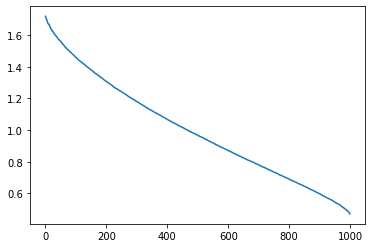

In [4]:
display(eVal0.shape, eVec0.shape)
plt.plot(np.diagonal(eVal0))

That was easy, now we can apply the 2 ways of estimating the pdf of eigen values like before. Conclusion: for a random matrix, Mp-pdf works quite well

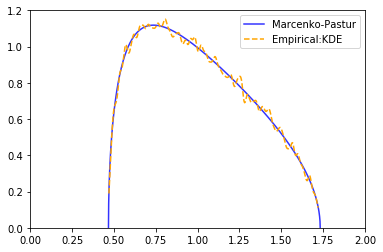

In [5]:
# Further confirm q = number of observations / number of columns
pdf_mp = mpPDF(1., q=x.shape[0] / (1.0 *x.shape[1]), pts=1000)
pdf_kde = fitKDE(np.diag(eVal0), bWidth=0.01) 

fig, ax = plt.subplots()
ax.set_xlim((0.0, 2.0))
ax.set_ylim((0.0, 1.2))
ax.plot(pdf_mp, color='blue',label='Marcenko-Pastur', alpha=0.8)
ax.plot(pdf_kde, color='orange',linestyle='--', label='Empirical:KDE')
ax.legend()

so far nothing much. We have not talked about de-noising or getting signals out of it at all
## Getting the signal back from a noisy matrix
given the empirical, fit it into the theoretical to get back the theoretical Variance
#### Rank of a matrix

In [6]:
w = np.random.normal(size=(1000,100))
cov = np.dot(w, w.T)
display(cov.shape)
print("Because w is 1000x100, rank is ", np.linalg.matrix_rank(cov))

cov+= np.diag(np.random.uniform(size=1000))
print("With noises, we can have the full rank ",np.linalg.matrix_rank(cov))

(1000, 1000)

Because w is 1000x100, rank is  100
With noises, we can have the full rank  1000


#### Adding noise to a matrix
Note: $q= N/T = 10$ => we have 10 times as many columns as observations

In [7]:
def getRndCov(nCols, nFacts):
    w = np.random.normal(size=(nCols, nFacts))
    # random cov matrix from the data
    # not full rank because nCols > nFacts: we have more noises than signals
    cov = np.dot(w, w.T) 
    cov+= np.diag(np.random.uniform(size=nCols)) # full rank cov
    return cov
    
def cov2corr(cov):
    # Derive the correlation matrix from the covariance matrix
    std = np.sqrt(np.diag(cov))
    corr = cov / np.outer(std, std)
    corr[corr <-1], corr[corr > 1] = -1, 1 # fixing the numerical error
    return corr

def corr2cov(corr, std):
    cov = corr*np.outer(std, std)
    return cov

alpha, nCols, nFact, q = .995, 10**3, 100, 10
# the signal
cov_real = np.cov(np.random.normal(size=(nCols*q, nCols)), rowvar=0)
# noise
noise = getRndCov(nCols, nFact)

cov = alpha * cov_real + (1-alpha) * noise
corr0 = cov2corr(cov)

In [8]:
print("Number of observations ", nCols*q)

Number of observations  10000


In [9]:
display(cov_real.shape, noise.shape)

(1000, 1000)

(1000, 1000)

#### Fitting the thereotical MP pdf on the list of eigen values (sorted)
=> to get the theoretical variance <br>
=> to get the theoretical maximum value of eigen-values

In [10]:
from scipy.optimize import minimize

def errPDFs(var, eVal, q, bWidth, pts=1000):
    # fitting error given a variance
    pdf0= mpPDF(var[0], q, pts)
    pdf_kde = fitKDE(eVal, bWidth, x = pdf0.index.values)
    
    sse = np.sum((pdf_kde-pdf0)**2)
    return sse

def findMaxEval(eVal, q, bWidth):
    out = minimize(lambda *x :errPDFs(*x), 
                   0.5, 
                   args=(eVal, q, bWidth),
                  bounds=((1e-5, 1-1e-5),))
    if out['success']:
        var = out['x'][0]
    else:
        var = 1
    eMax = var * (1+(1./q) **0.5)**2
    return eMax, var        

In [11]:
mpPDF(0.5, q, 1000)

0.233772    0.000000
0.234405    0.271589
0.235038    0.382859
0.235671    0.467410
0.236305    0.538002
              ...   
0.863695    0.147196
0.864329    0.127446
0.864962    0.104035
0.865595    0.073547
0.866228    0.000000
Length: 1000, dtype: float64

In [12]:
eVal0, eVec0 = getPCA(corr0)
eMax0, var0 = findMaxEval(np.diagonal(eVal0), q, bWidth=0.01)

In [13]:
display(eMax0, var0)

1.1726206549931628

0.6768546916853097

In [14]:
# Only pick the number of factors that are greater than the theoretical max of eigen values
nFacts0 = eVal0.shape[0] - np.diag(eVal0)[::-1].searchsorted(eMax0)
print("To pick {} from {} factors".format(nFacts0, eVal0.shape[0]))

To pick 100 from 1000 factors


In [15]:
pdf_kde[:10]

0.470335    0.189454
0.473670    0.248532
0.478444    0.340362
0.481384    0.398210
0.484198    0.452289
              ...   
1.699483    0.185938
1.701457    0.182601
1.706445    0.170493
1.716201    0.128778
1.719146    0.111171
Length: 1000, dtype: float64

In [16]:
np.diagonal(eVal0)[:10]

array([6.26164379, 6.15572132, 6.11975422, 5.9853394 , 5.88495411,
       5.85042142, 5.71103377, 5.68547445, 5.57657373, 5.51716278])

In [17]:
pdf_kde = fitKDE(np.diagonal(eVal0), bWidth=0.01, x = None)
theoretical_df = mpPDF(var0, q, pts=1000)

### Everything to the right of the theoretical max values can be considered the signals
we can keep only the eigenvectors associated with these large signals.

Note: pdf_kde is sorted by <b>descending</b> of the eigen values. Good thing that the plotting function takes care of the order

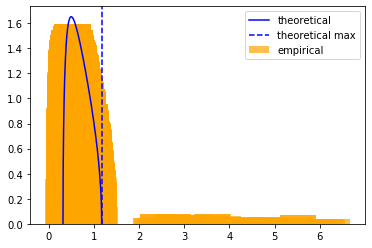

In [18]:
fig, ax = plt.subplots()
ax.bar(x=pdf_kde.index, height=pdf_kde, alpha=0.7,color='orange', label='empirical')
ax.plot(theoretical_df.index, theoretical_df, color='blue', label='theoretical')
max_theoretical= np.max(theoretical_df.index)
ax.axvline(max_theoretical, color='blue', linestyle='--', label='theoretical max')
ax.legend()

# Graph of explained variance

Text(0.5, 1.0, 'Explained variance')

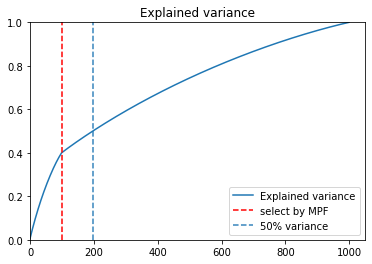

In [20]:
variance = np.diagonal(eVal0)
variance_cumsum = np.cumsum(variance / np.sum(variance))

fig, ax = plt.subplots()
ax.plot(variance_cumsum, label='Explained variance')
ax.axvline(99, label='select by MPF', linestyle='--', color='red')
ax.axvline(np.argmax(variance_cumsum >= 0.5), 
           label='50% variance', linestyle='--', alpha=0.9)
ax.set_xlim(xmin=0)
ax.set_ylim(ymin=0, ymax=1)
ax.legend()
ax.set_title("Explained variance")

## Denoises according to the set of eigenfactors
continuing the code above

In [21]:
def denoisedCorr(eVal, eVec, nFacts):
    # remove noise by fixing eigenvalues that are considered random
    # as opposed to simply getting rid of the eigen vectors like in PCA
    eVal_ = np.diag(eVal).copy()
    
    # the replacement value is such that the trace of the eigenvalues matrix is preserved
    replace_val = eVal_[nFacts:].sum() / float(eVal_.shape[0] - nFacts)
    eVal_[nFacts:] = replace_val
    
    eVal_ = np.diag(eVal_)
    corr1 = np.dot(eVec, eVal_).dot(eVec.T)
    corr1 = cov2corr(corr1)
    return corr1

corr1 = denoisedCorr(eVal0, eVec0, nFacts0)
eVal1, eVec1 = getPCA(corr1)

alternatively, denoising by targetted shrinkage. The formula looks similar to that in here:
https://scikit-learn.org/stable/modules/generated/sklearn.covariance.ledoit_wolf.html

In [22]:
def denoisedCorr2(eVal, eVec, nFacts, alpha=0):
    # left
    eValL, eVecL = eVal[:nFacts, :nFacts], eVec[:, :nFacts]
    
    # right
    eValR, eVecR = eVal[nFacts:, nFacts:], eVec[:, nFacts:]
    
    corr0 = np.dot(eVecL, eValL).dot(eVecL.T)
    corr1 = np.dot(eVecR, eValR).dot(eVecR.T)
    corr2 = corr0 + alpha * corr1 + (1-alpha) * np.diag(np.diag(corr1))
    
    # alpha = 0 means: only add the diagonal
    return corr2

corr2 = denoisedCorr2(eVal0, eVec0, nFacts0, alpha=0.5)
eVal2, eVec2 = getPCA(corr2)

# Apply and get experimental portfolio

In [23]:
from scipy.linalg import block_diag

def formBlockMatrix(nBlocks, bSize, bCorr):
    block = np.ones((bSize, bSize)) * bCorr
    # set the digonal to 1
    block[range(bSize), range(bSize)] = 1
    
    corr = block_diag(*([block] * nBlocks))
    return corr

# illustrate the function
bSize=5
bCorr = 0.2
block = np.ones((bSize, bSize)) * bCorr 
block[range(bSize), range(bSize)] = 1
display(block)

# Each blog can be thought of as an economic sector
display(block_diag(*([block] * 2)))

array([[1. , 0.2, 0.2, 0.2, 0.2],
       [0.2, 1. , 0.2, 0.2, 0.2],
       [0.2, 0.2, 1. , 0.2, 0.2],
       [0.2, 0.2, 0.2, 1. , 0.2],
       [0.2, 0.2, 0.2, 0.2, 1. ]])

array([[1. , 0.2, 0.2, 0.2, 0.2, 0. , 0. , 0. , 0. , 0. ],
       [0.2, 1. , 0.2, 0.2, 0.2, 0. , 0. , 0. , 0. , 0. ],
       [0.2, 0.2, 1. , 0.2, 0.2, 0. , 0. , 0. , 0. , 0. ],
       [0.2, 0.2, 0.2, 1. , 0.2, 0. , 0. , 0. , 0. , 0. ],
       [0.2, 0.2, 0.2, 0.2, 1. , 0. , 0. , 0. , 0. , 0. ],
       [0. , 0. , 0. , 0. , 0. , 1. , 0.2, 0.2, 0.2, 0.2],
       [0. , 0. , 0. , 0. , 0. , 0.2, 1. , 0.2, 0.2, 0.2],
       [0. , 0. , 0. , 0. , 0. , 0.2, 0.2, 1. , 0.2, 0.2],
       [0. , 0. , 0. , 0. , 0. , 0.2, 0.2, 0.2, 1. , 0.2],
       [0. , 0. , 0. , 0. , 0. , 0.2, 0.2, 0.2, 0.2, 1. ]])

## True covariance matrix

In [35]:
def formTrueMatrix(nBlocks, bSize, bCorr):
    # Generate blocks of correlation matrix
    corr0 = formBlockMatrix(nBlocks, bSize, bCorr)
    corr0 = pd.DataFrame(corr0)
    cols = corr0.columns.tolist()
    
    # randomly shuffle the cols
    np.random.shuffle(cols)
    
    corr0 = corr0[cols].loc[cols].copy(deep=True)
    
    # Noises. Note: corr0 is a square matrix with each of dimension of size (nBlocks * bSize)
    print(corr0.shape[0])
    std0 = np.random.uniform(0.05, 0.2, corr0.shape[0])
    
    cov0 = corr2cov(corr0, std0)
    mu0 = np.random.normal(std0, std0, cov0.shape[0]).reshape(-1, 1)
    return mu0, cov0

from sklearn.covariance import LedoitWolf

nBlocks, bSize, bCorr = 10, 50, .5
np.random.seed(0)

mu0, cov0 = formTrueMatrix(nBlocks, bSize, bCorr)
display(mu0.shape, cov0.shape)

500


(500, 1)

(500, 500)

## Empirical covariance matrix
ie, what we observed

In [36]:
def simCovMu(mu0, cov0, nObs, shrink=False):
    # nObs depend on how many observations we are simulating
    # ideally, nObs should be larger than the size of cov0
    x = np.random.multivariate_normal(mu0.flatten(), cov0, size=nObs)
    
    # take the empirical mean
    # and the empirical Covariance
    mu1 = x.mean(axis=0).reshape(-1, 1)
    if shrink:
        cov1 = LedoitWolf().fit(x).covariance_
    else:
        cov1= np.cov(x, rowvar=0)
    return mu1, cov1

def deNoiseCov(cov0, q, bWidth):
    corr0= cov2corr(cov0)
    eVal0, eVec0 = getPCA(corr0)
    eMax0, var0 = findMaxEval(np.diag(eVal0), q, bWidth)
    nFacts0 =eVal0.shape[0] - np.diag(eVal0)[::-1].searchsorted(eMax0)
    corr1 =denoisedCorr(eVal0, eVec0, nFacts0)
    cov1 = corr2cov(corr1, np.diag(cov0) **0.5)
    return cov1
    
mu1, cov1 = simCovMu(mu0, cov0,nObs=10)
cov1_denoised = deNoiseCov(cov1, 10, bWidth=0.01)

display(mu1.shape, cov1.shape)

(500, 1)

(500, 500)

Optimial, portfolio, likely following this mathematical setup:
$$argmin w : w^T \Sigma w$$
such that $$R^T W = \mu$$

In [37]:
def optPort(cov, mu=None):
    ## get the minimum variance portfolio
    ## of the risky asset portfolio
    inv = np.linalg.inv(cov)
    ones = np.ones(shape=(inv.shape[0], 1))
    if mu is None:
        mu = ones
    
    w = np.dot(inv, mu)
    w/= np.dot(ones.T, w)
    return w

In [38]:
nObs, nTrials, bWidth, shrink, minVarPortf = 1000, 1000, 0.01, False, True


w1 = pd.DataFrame(columns=range(cov0.shape[0]),
                  index=range(nTrials), dtype=float)
w1_d = w1.copy(deep=True)
np.random.seed(0)

for i in range(nTrials):
    mul, cov1 = simCovMu(mu0, cov0, nObs, shrink=shrink)
    if minVarPortf: mu1=None
    cov1_d = deNoiseCov(cov1, nObs * 1./cov1.shape[1], bWidth)
    w1.loc[i] = optPort(cov1, mu1).flatten()
    w1_d.loc[i] = optPort(cov1_d, mu1).flatten()

In [39]:
w1.shape

(1000, 500)

In [40]:
w0 = optPort(cov0, None if minVarPortf else mu0)
w0 = np.repeat(w0.T, w1.shape[0], axis=0)

rmsd = np.mean((w1-w0).values.flatten() **2)**.5
rmsd_d = np.mean((w1_d - w0).values.flatten()**2) **.5
print(rmsd, rmsd_d)

0.0049592045554728535 0.001138960190094047
